* TODO Introduction
- Characterise the behaviour by exploring the data
- Formulate the computational problem from the characterisation
- Propose and implement computational solutions
- Discuss the results
* Data Exploration

We are going to use scipy for the data fit and seaborn for the

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sns.set(color_codes=True)

# Data Cleaning

Import the files.

In [9]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


As we can see the data has quite a few not a number values. We would
need to clean it, but first lets see how much of the data is actually
NaN.

In [11]:
(len(train_data) - train_data.count()) / len(train_data)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

As can be see 77% of the data in the Cabin column in NaN, 20% is in
Age and a few entries in Embarked. The rest is clean.

One first though is that the available data which exists in the cabin
column can introduce bias since it is likely to come from
survivors. Let us quickly check that before we proceed. We are going
to test the null hypothesis that there is no relationship between
survived people and the availability of the cabin data. The way we can
do this is using a Pearson test.

In [14]:
from scipy.stats import pearsonr
pearsonr(~train_data[['Cabin']].isnull().values, train_data[['Survived']])

(array([0.31691152]), array([3.09089104e-22]))

The results are a Pearson $r=0.317$ and a $p=3.09\times10^{-22}$. The
small $p-value$ indicates that we can confirm the null
hypothesis. Even though $p-values$ are not very reliable with such a
small data range we can be more certain considering the rather small
Pearson $r$ coefficient of linear dependency. The conclusion is that,
I am confident that there was no bias in the cabin data and I can hope
that it can be infered from other features.

Now we move to the missing values in the age. We have two options on
how to fill them. The lazy approach would be a choice between mean or
median. In many applications involving statistical data there will be
noise and outliers which affects the value the mean provides. Hence,
the median would often be picked instead of the mean. In our data,
however, there is no noise since the age column contains a limited
number range i.e. age has no noise. For this reason, we can fill the
values with the mean. We can see more confirmation here.

In [15]:
train_data['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

The data shows that the minimum age is about 6 months and the maximum
age is 80 years which tells us that no crazy outliers are hidding in
the data to affect the mean. So the lazy approach can be done with
filling the mean. However, we can hope for something better which
leads us to option 2 - the smart approach. We can hope to find an
estimate for the missing age values by looking at other features. I am
an optimist and will go for option 2.

Finally, the missing data in the embarked column is so small that I
will just filter it out.

In [16]:
train_data = train_data.drop(['Cabin'], axis=1)

To summarise the missing age and cabin values will be filled by
looking at other features. Let's analyse the data now and see what
they can be. Furhtermore, the analysis will help us later to engineer
new features and hopefully make better predictions.

# Analysis

Lets explore some of the data to get a sense of what is going on. We
are going to look at the age, male/female, ticket fare, embarkment
city and family data and how it relates to survivability.

To facilitate the analysis we need to first remove the remaining
missing values (before figuring out how to fill them). This can be
done as below.

In [17]:
clean_train_data = train_data.dropna(subset=['Age', 'Embarked'])
(len(clean_train_data) - clean_train_data.count()) / len(clean_train_data)

PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Embarked       0.0
dtype: float64

## Age

We can start by exporing the relationship between age and
survivability. We can make a null hypothesis assumption that the
younger you are the more chance you have of survival. Having watched
the Titanic movie this statement certainly makes sense in my head but
we cannot blindly trust James Cameron can we?

We can check if he did his homework by plotting the histograms of
survival (0 Nope / 1 Yep) for age and then compare the kernel density
estimate (KDE). From the KDE we can estimate the probability density
function (PDF) of the the age-survival random variable.

Lets plot the histograms. First the total distribution of all
passangers and then the passangers than survived.

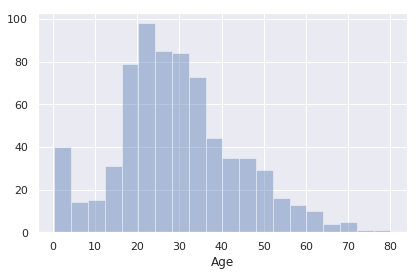

In [18]:
fig = plt.figure()
sns.distplot(clean_train_data['Age'], bins=20, kde=False)
fig.tight_layout()
plt.show()

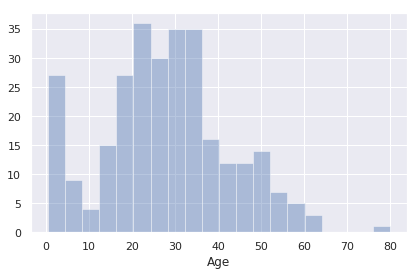

In [19]:
fig = plt.figure()
sns.distplot(clean_train_data['Age'][clean_train_data['Survived'] == 1], bins=20, kde=False)
fig.tight_layout()
plt.show()

To compute the KDE seaborn will put a Gaussian distribution centered
at each bin with predefined parameters and then sum them. It will then
normalize the result so that the integral is equal to unity. In a way
it will smooth the data which is dictated by the bandwith parameter
(bw in python). This is what controls the trade-off between the bias
and variance of the estimator. We are going to leave the default
bandwith here, see how well it works and determine if we need to play
with it.

Lets plot the two KDE and compare them.

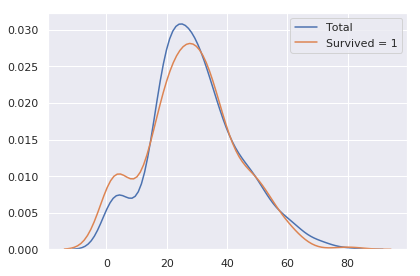

In [20]:
fig = plt.figure()
sns.kdeplot(clean_train_data['Age'], label='Total')
sns.kdeplot(clean_train_data['Age'][clean_train_data['Survived'] == 1], label='Survived = 1')
fig.tight_layout()
plt.show()

The integral of both curves is equal to unity so we can directly
compare them. From the plot we can do a quick qualitative comparison
(high/low) and what we can see is that:

- Age < 10 (Group 1): High proportion survived,
- 10 < Age < 30 (Group 2): Low proportion survived,
- 30 < Age < 60 (Group 3): High proportion survived,
- Age > 60 (Group 4): Low proportion survived.

What this data tells us is that survivability is correlated with age
in a categorical manner and not absolute. Or in other words people in
Group 1 were prioratised, Group 2 and 3 were not prioratised and Group
4 was in between. This statement certainly makes sense (thank you Mr
Cameron), however, we need to look into the male/female distribution
and the family relations in order to comment more on how this
information can help us to fill the missing age values.

## Gender

In [21]:
clean_train_data['Sex'].head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

## Family

## Ticket Fare

/home/nik/Envs/ds/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

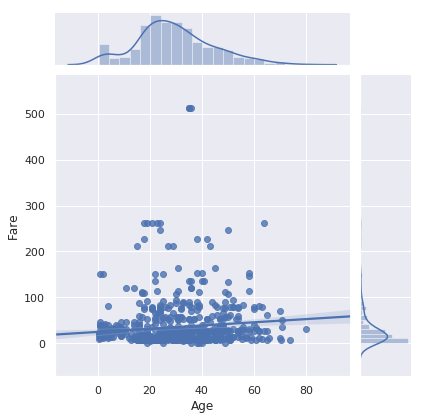

In [22]:
fig = plt.figure()
sns.jointplot(data=train_data, x='Age', y='Fare', kind='reg')
fig.tight_layout()
plt.show()

/home/nik/Envs/ds/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

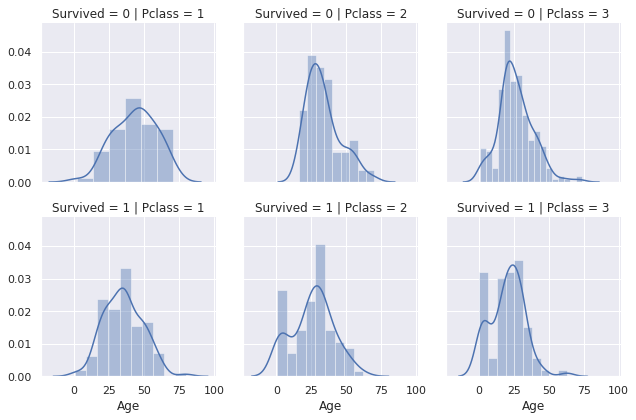

In [23]:
fig = plt.figure()
g = sns.FacetGrid(train_data, row='Survived', col='Pclass')
g.map(sns.distplot, "Age")
fig.tight_layout()
plt.show()

## Correlation

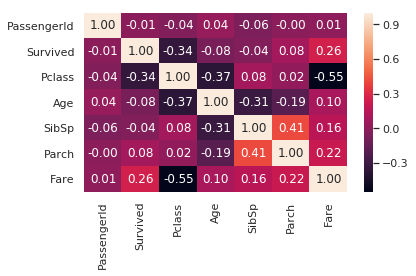

In [24]:
fig = plt.figure()
sns.heatmap(train_data.corr(), annot=True, fmt=".2f")
fig.tight_layout()
plt.show()

# Data Standardisation

During the data exploration we noticed that some of the values are categorical i.e.
male/female. To facilitate the use of this date in machine learning models we need to
encode the data with a method such as the one-hot encoder.

For this we can use the preprocessing module of scikit. Lets see again
which columns would require an encoding.

In [25]:
from sklearn import preprocessing

train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

It seems that we would need to encode the columns: 'Sex', 'Parch' and 'Embarked'.

First lets place integer labels for the categorical data.

In [28]:
enc_labels = preprocessing.LabelEncoder()
training_cat_labels = train_data[['Sex', 'Parch', 'Embarked']].apply(enc_labels.fit_transform)
testing_cat_labels = test_data[['Sex', 'Parch', 'Embarked']].apply(enc_labels.fit_transform)
training_cat_labels.head()

TypeError: ("'<' not supported between instances of 'float' and 'str'", 'occurred at index Embarked')

For SVM we would also need to use the one hot encoder.

In [27]:
onehot = preprocessing.OneHotEncoder()

onehot.fit(training_cat_labels)
onehot_labels = onehot.transform(training_cat_labels).toarray()
onehot_labels

NameError: name 'training_cat_labels' is not defined